In [5]:
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim 
import torchvision.datasets as datasets
import matplotlib.pyplot as plt 
import seaborn as sns 
from torch.utils.data import DataLoader
from PIL import Image 
import numpy as np 
import json 
import os

# Transformation for Train and Test Set

In [8]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),   # ✅ REQUIRED
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),   # already included ✔️
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}


# Loading the Dataset with Dataloaders

In [10]:
# load the Flowers dataset
train_dataset = datasets.ImageFolder(
    root='./dataset/train',
    transform=transform['train']
)

val_dataset = datasets.ImageFolder(
    root='./dataset/test',
    transform=transform['test']
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Pretrained Model Learning

In [11]:
# Load a pretrained VGG-16 model

model = models.vgg16(pretrained=True)

# freeze all layers except the final fully connected 
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier to train only the last layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(train_dataset.classes))

c:\Users\chara\anaconda3\envs\dlenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chara\anaconda3\envs\dlenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\chara/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [08:16<00:00, 1.12MB/s] 


# Setting up the loss and optimizer

In [17]:
from torchsummary import summary

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.cpu()
summary(model, (3, 224, 224))
model.to(device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Define the training loop with Validation

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0 
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct, total = 0,0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]: .4f}, val losss: {val_losses[-1]: .4f}")
        
        # Save the best Model
        if val_accuracy > best_accuracy:
            best_accuracy =val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print('Model Checkpoint Saved!')
        
    return train_losses, val_losses, val_accuracies

# Start Training

Epoch 1/2, Train Loss:  0.2051, val losss: 0.15822316519916058: .4f
Model Checkpoint Saved!
Epoch 2/2, Train Loss:  0.1722, val losss: 0.16185655010243258: .4f


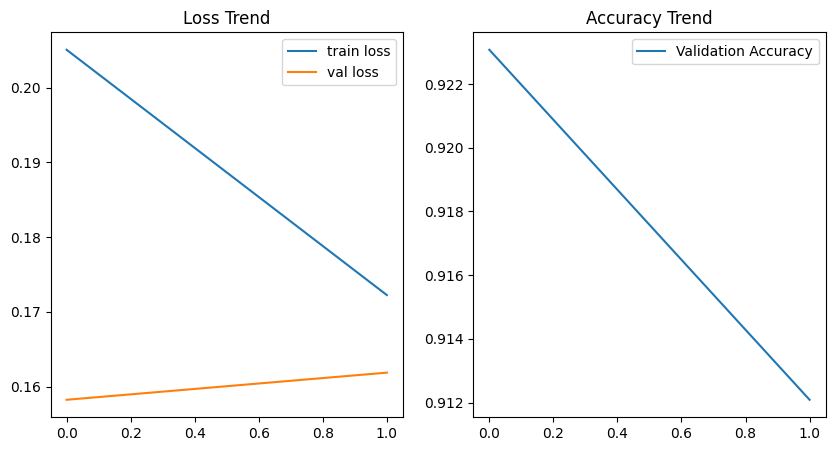

In [22]:
# train the model
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)

# Plot accuracy and loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label = 'val loss')
plt.legend()
plt.title('Loss Trend')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Trend")
plt.show()

# Load the best model

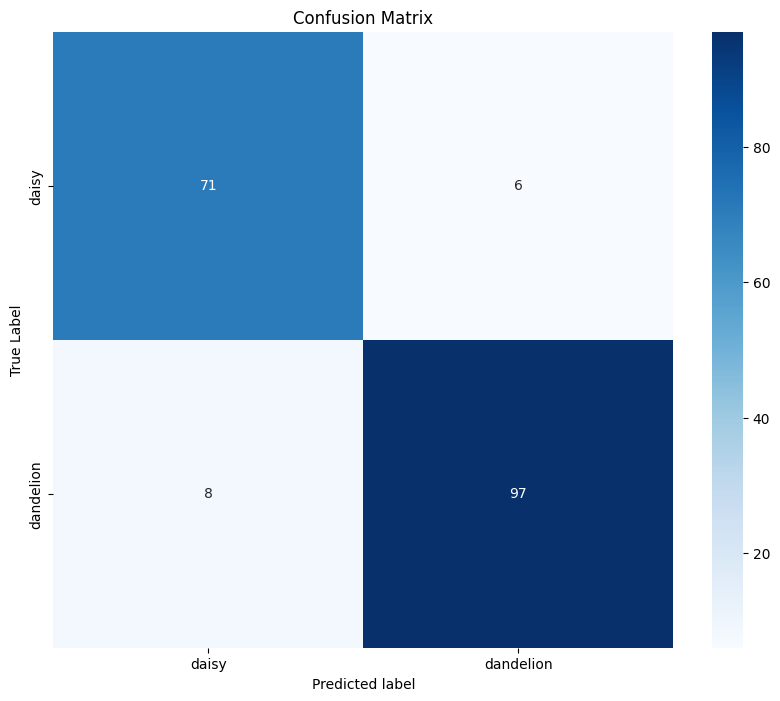

In [23]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Confusion matrix visualization
def plot_confusion_matrix(model, dataloader):
    from sklearn.metrics import confusion_matrix
    import pandas as pd 
    
    all_preds, all_labels = [],[]
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, val_loader)

# Model Inferencing

In [24]:
# Inference function

def infer(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform['test'](image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        
    probabilities = torch.nn.functional.softmax(output[0],dim=0)
    
    # Get the top k probabilities where k is the minimum between 5 and the no.of classes
    k = min(5, probabilities.size(0)) # Ensure k is within the valid range
    top5_prob, top5_catid = probabilities.topk(k)
    results = [(train_dataset.classes[catid], prob.item()) for catid,prob in zip(top5_catid,top5_prob)]
    return results
    

In [25]:
from PIL import Image 
import matplotlib.pyplot as plt 

def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

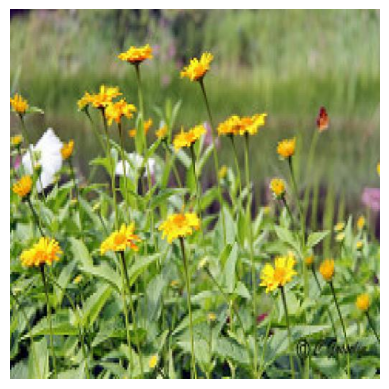

daisy : 0.6432
dandelion : 0.3568


In [26]:
image_path = './dataset/train/daisy/10300722094_28fa978807_n_jpg.rf.1661f5022c8b1e78ad7643d1e8fd8e42.jpg'

show_image(image_path)
results = infer(image_path,model)
for label, prob in results:
    print(f"{label} : {prob:.4f}")